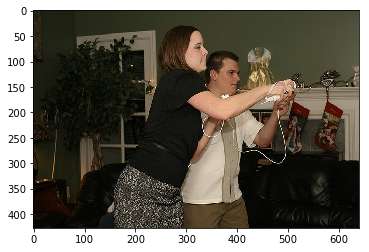

net.blobs['probs'] (1, 1, 8801)
im.shape (1, 3, 227, 227) float64


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, cv2, random

caffe_root = '/home/weiying1/hyg/caffecode/caffe/'
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
import caffe

sys.path.append('./examples/coco_caption')

# iter_num = 110000
# net = caffe.Net('./examples/coco_caption/lstm_lm.deploy.prototxt',
#                 './examples/coco_caption/lstm_lm_iter_%d.caffemodel' % iter_num, caffe.TEST)
# print net.blobs['probs'].data.shape

iter_num = 110000
net = caffe.Net('./examples/coco_caption/lrcn.deploy.prototxt',
                './examples/coco_caption/lrcn_iter_%d.caffemodel' % iter_num, caffe.TEST)

im = caffe.io.load_image('examples/coco_caption/COCO_val2014_000000229427.jpg')
plt.imshow(im)
plt.show()
im = caffe.io.resize_image(im, (227, 227))
im = im.transpose(2, 0, 1)
im = im[np.newaxis, :, :, :]
c0 = np.ones((227, 227)) * 104
c1 = np.ones((227, 227)) * 117
c2 = np.ones((227, 227)) * 123
mean = np.zeros((1, 3, 227, 227))
mean[0, 0, :] = c0
mean[0, 1, :] = c1
mean[0, 2, :] = c2
im = im * 255 - mean
# im = im.astype('S32')
print "net.blobs['probs']", net.blobs['probs'].data.shape
print 'im.shape', im.shape, im.dtype

In [2]:
def predict_single_word_pic(net, im, previous_word, output='probs'):
    cont = 0 if previous_word == 0 else 1
    cont_input = np.array([cont])
    word_input = np.array([previous_word])
    net.forward(data = im, cont_sentence = cont_input, input_sentence = word_input)
    output_preds = net.blobs[output].data[0, 0, :]
    return output_preds

In [3]:
first_word_dist = predict_single_word_pic(net, im, 0)
vocabulary = ['<EOS>'] + [line.strip() for line in
                          open('examples/coco_caption/h5_data/buffer_100/vocabulary.txt').readlines()]
print len(vocabulary)
print np.array(vocabulary)[0:50]

8801
['<EOS>' '<unk>' 'a' 'on' 'of' 'the' 'in' 'with' 'and' 'is' 'man' 'to'
 'sitting' 'an' 'two' ',' 'standing' 'at' 'people' 'are' 'next' 'white'
 'woman' 'table' 'street' 'that' 'holding' 'it' 'person' 'large' 'some'
 'down' 'top' 'group' 'up' 'field' 'small' 'near' 'tennis' 'his' 'front'
 'black' 'plate' 'room' 'train' 'dog' 'riding' 'red' 'by' 'young']


In [4]:
# Arrange small real number first.
top_preds = np.argsort(-1 * first_word_dist)
print top_preds[:10]
print [vocabulary[index] for index in top_preds[:10]]

[ 2 14  5 77 18 93 13 10 64 30]
['a', 'two', 'the', 'three', 'people', 'several', 'an', 'man', 'there', 'some']


In [5]:
def softmax(softmax_inputs, temp):
    shifted_inputs = softmax_inputs - softmax_inputs.max()
    exp_outputs = np.exp(temp * shifted_inputs)
    exp_outputs_sum = exp_outputs.sum()
    if np.isnan(exp_outputs_sum):
        return exp_outputs * float('nan')
    assert exp_outputs_sum > 0
    if np.isinf(exp_outputs_sum):
        return np.zeros_like(exp_outputs)
    eps_sum = 1e-20
    return exp_outputs / max(exp_outputs_sum, eps_sum)

def random_choice_from_probs(softmax_inputs, temp = 1):
    # temperature of infinity == take the max
    if temp == float('inf'):
        return np.argmax(softmax_inputs)
    probs = softmax(softmax_inputs, temp)
    r = random.random()
    cum_sum = 0.
    for i, p in enumerate(probs):
        cum_sum += p
        if cum_sum >= r: return i
    return 1  # return UNK?

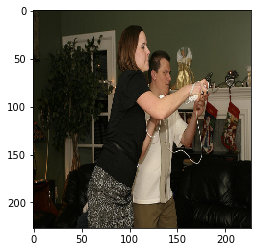

[2, 10, 8, 22, 16, 6, 40, 4, 2, 307, 0]
['a', 'man', 'and', 'woman', 'standing', 'in', 'front', 'of', 'a', 'tv', '<EOS>']


In [32]:
def generate_sentence(net, temp = float('inf'), output = 'predict', max_words = 50):
    cont_input = np.array([0])
    word_input = np.array([0])
    sentence = []
    while len(sentence) < max_words and (not sentence or sentence[-1] != 0):
        net.forward(cont_sentence = cont_input, data = im, input_sentence = word_input)
        output_preds = net.blobs[output].data[0, 0, :]
        sentence.append(random_choice_from_probs(output_preds, temp = temp))
        cont_input[0] = 1
        word_input[0] = sentence[-1]
    return sentence

plt.imshow((im + mean)[0].transpose(1, 2, 0).astype('uint8'))
plt.show()
sentence = generate_sentence(net, temp = 20)
print sentence
print [vocabulary[index] for index in sentence]

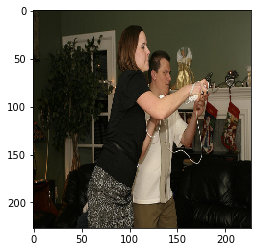

[2, 10, 8, 22, 19, 56, 2, 300, 91, 0]
['a', 'man', 'and', 'woman', 'are', 'playing', 'a', 'video', 'game', '<EOS>']


In [42]:
plt.imshow((im + mean)[0].transpose(1, 2, 0).astype('uint8'))
plt.show()
sentence = generate_sentence(net)
print sentence
print [vocabulary[index] for index in sentence]

In [53]:
vocabulary.index('large')
!cat examples/coco_caption/COCO_val2014_000000229427

{"license": 1,"file_name": "COCO_val2014_000000229427.jpg","coco_url": "http://images.cocodataset.org/val2014/COCO_val2014_000000229427.jpg","height": 427,"width": 640,"date_captured": "2013-11-21 22:28:38","flickr_url": "http://farm3.staticflickr.com/2132/2115076248_60333baec7_z.jpg","id": 229427}
{"image_id": 229427,"id": 70214,"caption": "A man and a woman holding game controllers while standing in a room."}
{"image_id": 229427,"id": 75572,"caption": "A man and woman playing a Wii game together at Christmastime."}
{"image_id": 229427,"id": 75623,"caption": "Two friends playing an interactive video game and getting competitive."}
{"image_id": 229427,"id": 78527,"caption": "Young couple competing with each other while playing a video game."}
{"image_id": 229427,"id": 79190,"caption": "The woman and the man stand together playing the video game in the house"}

